# Imports & private packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Private packages via Google Drive

In [7]:
cd "/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/sgte"

/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/sgte


In [8]:
!pip install -e .

Obtaining file:///content/drive/Othercomputers/PC/Masterarbeit/5%20Programmcodes/packages/sgte
  Attempting uninstall: sgte
    Found existing installation: SGTE 0.1.0
    Can't uninstall 'SGTE'. No files were found to uninstall.
  Running setup.py develop for sgte


In [4]:
cd "/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/thermoclassifier"

/content/drive/Othercomputers/PC/Masterarbeit/5 Programmcodes/packages/thermoclassifier


In [5]:
!pip install -e .

Obtaining file:///content/drive/Othercomputers/PC/Masterarbeit/5%20Programmcodes/packages/thermoclassifier
  Running setup.py develop for thermoclassifier


## Imports

In [9]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from thermoclassifier.dataset.dataset_creator import DatasetCreator
from thermoclassifier.elements.net import ElementClassifier
from thermoclassifier.dataset.encoding import Encoder

# Training routine

In [11]:
def epoch(net, train_loader, loss_func, optimizer, batch_size, seq_len, measurement='G'):
    epoch_losses = np.zeros([len(train_loader), ])
    correct = 0
    incorrect = 0
    
    for i, d in enumerate(train_loader):
        # Scale inputs and get predictions
        inp = d[:, :, :-1]#.squeeze(1)
        inp[:, :, 0] /= 1000

        # Add random noise to heat capacity values to simulate real measurements
        #d[:, :, 1] += torch.normal(mean=0, std=1.25, size=(d.shape[0], d.shape[1], ))

        predictions = net(inp.float().to(device))
        
        # Each batch consists of measurement batches, where seq_len measurements are put into one batch. In such a 
        # measurement batch, every measurement has the same label as it needs to be from the same element an phase. 
        # This leads to a target array where the target class is contained for each measurement in the measurement 
        # batch. With this, CrossEntropyLoss would not work as the predictions are made for the whole measurement 
        # batch and CEL therefore expects only on class label per measurement batch. Therefore, only the first 
        # element of the last dimension of d is considered as target (all the entries in the last dimension are the 
        # same anyways so it could be any entry)
        targets = d[:, :, -1][:, 0].long().to(device)

        correct += (predictions.argmax(dim=-1) == targets).sum().item()
        incorrect += len(targets) - (predictions.argmax(dim=-1) == targets).sum().item()
        
        # Calculate the loss
        loss = loss_func(predictions, targets)
        epoch_losses[i] = loss
        
        # Backward step
        net.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = correct/(correct + incorrect)
    return epoch_losses.mean(), accuracy

In [12]:
from torch.nn.modules.activation import Softmax
# Training and testing routines

def train(net, optimizer, train_loader, test_loader, batch_size, seq_len, measurement='G', nr_epochs=10000):
    loss_func = nn.CrossEntropyLoss()
    
    losses = np.zeros([nr_epochs, ])
    accuracies = np.zeros([nr_epochs, ])

    best_loss, _ = epoch(net, train_loader, loss_func, optimizer, batch_size, seq_len, measurement=measurement)
    best_net = net
    
    for i in range(nr_epochs):
        losses[i], accuracies[i] = epoch(net, train_loader, loss_func, optimizer, batch_size, seq_len, measurement=measurement)
        if losses[i] < best_loss:
            best_net = net
            best_loss = losses[i]

        if i % 10 == 0:
            print('Epoch ', i)
            print('Loss: ', losses[i])
            print('Training accuracy: ', accuracies[i])
            #test(best_net, test_loader)
    
    return best_net, losses, accuracies

def test(net, test_loader): 
    correct = 0
    incorrect = 0
    
    for d in test_loader:
        inp = d[:, :, :-1]#.squeeze(1)
        inp[:, :, 0] /= 1000
        predictions = net(inp.float().to(device)).squeeze()#.argmax()
        targets = d[:, :, -1][:, 0].long().to(device)
        
        correct += (predictions.argmax(dim=-1) == targets).sum().item()
        incorrect += len(targets) - (predictions.argmax(dim=-1) == targets).sum().item()  
        #print(predictions.argmax(dim=-1), targets, Softmax()(predictions).amax(dim=-1))

    accuracy = correct/(correct + incorrect)
    print('Test accuracy: ', accuracy)
    
    return accuracy

# Run

## Network definition

In [19]:
# Hyperparameters
seq_len = 10
measurement = 'C'
batch_size = 256
nr_epochs = 250
lr = 0.001
hidden_size_linear = 128
hidden_layers = 2
step = 0.05

In [15]:
def create_data_loaders(elements, splits, seq_len, validation=False, measurement='G', user='element', batch_size=128, shuffle=True, step=1.):
    dc = DatasetCreator(elements=elements,  splits=splits, validation=validation, seq_len=seq_len, measurement=measurement, user=user, step=step)
    train_dataset, test_dataset, val_dataset = dc.get_datasets()

    # Create the DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=shuffle)
    if val_dataset:
        val_loader = DataLoader(val_dataset)
    else:
        val_loader = None

    return train_loader, test_loader, val_loader

In [21]:
# Create the network
t = True
net = ElementClassifier(train, in_features=seq_len * 2, hidden_size_linear=hidden_size_linear, hidden_layers=hidden_layers)

# Check if cuda is available and send net to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)

optimizer = Adam(net.parameters(), lr=lr)

## Train

In [17]:
elements = None

train_loader, test_loader, val_loader = create_data_loaders(elements, (0.8, 0.2), seq_len=seq_len, measurement=measurement, step=step)

Dataset shape:  (205584, 10, 3)


In [22]:
best_net, losses, accuracies = train(net, optimizer, train_loader, test_loader, batch_size, seq_len, measurement, nr_epochs)
test(best_net, test_loader)

Epoch  0
Loss:  1.0402303920373757
Training accuracy:  0.6638113861000856
Epoch  10
Loss:  0.25112168046262745
Training accuracy:  0.9100221807144525
Epoch  20
Loss:  0.1794321071020401
Training accuracy:  0.9398153552805666
Epoch  30
Loss:  0.13487410503969885
Training accuracy:  0.9546851895089112
Epoch  40
Loss:  0.11451096690648746
Training accuracy:  0.95839656782629
Epoch  50
Loss:  0.11131925152802484
Training accuracy:  0.9634358704957584
Epoch  60
Loss:  0.09413892498579486
Training accuracy:  0.9656198925986458
Epoch  70
Loss:  0.08894135977440602
Training accuracy:  0.9687670246711806
Epoch  80
Loss:  0.07645864214014444
Training accuracy:  0.9721914156743715
Epoch  90
Loss:  0.07235778130848232
Training accuracy:  0.9734123278076114
Epoch  100
Loss:  0.07310931078739599
Training accuracy:  0.973529068409993
Epoch  110
Loss:  0.06916697218135584
Training accuracy:  0.9753288193633746
Epoch  120
Loss:  0.06475094252416091
Training accuracy:  0.9766518795236984
Epoch  130
Loss

0.9501263362487852

In [ ]:
test(best_net, test_loader)

In [ ]:
torch.save(best_net, 'ElementClassifier_9806.pth')
# PLOTS!!!

<class 'numpy.ndarray'>


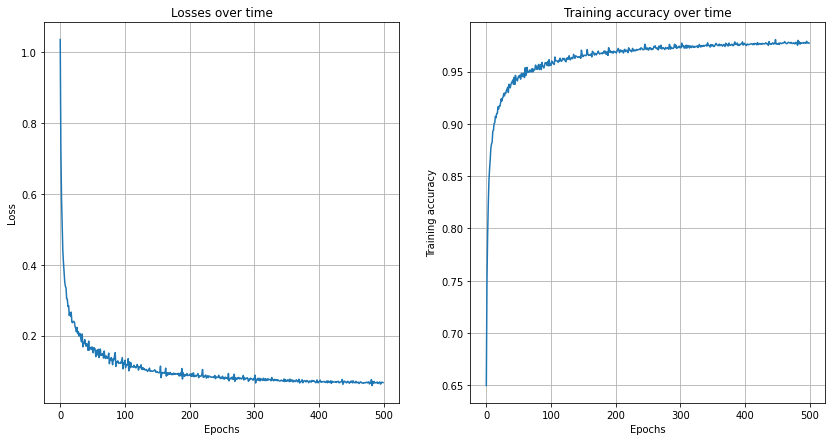

In [ ]:
print(type(losses))
fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs'), ax[0].set_ylabel('Loss')
ax[0].set_title('Losses over time')
ax[0].grid()
ax[1].plot(accuracies)
ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('Training accuracy')
ax[1].set_title('Training accuracy over time')
ax[1].grid()
plt.show()

# Test on Barin data

In [ ]:
net = torch.load('/content/ElementClassifier_9782_3.pth').to(device)

In [ ]:
inp = torch.tensor([[[ .3,   11.403],
                    [ .7,   22.25],
                    [ .8,   23.364],
                    [.9,   24.248],
                    [1.0,   24.979]]]).to(device)

In [ ]:
out = net(inp)

In [ ]:
print(Encoder()(out.argmax(dim=-1).item()))
print(Softmax(dim=-1)(out).amax(dim=-1))

B
tensor([1.0000], grad_fn=<AmaxBackward0>)


In [ ]:
test(net, test_loader)

Test accuracy:  0.9772111058201572


0.9772111058201572